##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Rock, Paper & Scissors with TensorFlow Hub - TFLite

## Setup

In [2]:
try:
    %tensorflow_version 2.x
except:
    pass

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [3]:
import numpy as np
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tqdm import tqdm

print("\u2022 Using TensorFlow Version:", tf.__version__)
print("\u2022 Using TensorFlow Hub Version: ", hub.__version__)
print('\u2022 GPU Device Found.' if tf.test.is_gpu_available() else '\u2022 GPU Device Not Found. Running on CPU')

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


• Using TensorFlow Version: 2.12.0
• Using TensorFlow Hub Version:  0.13.0
• GPU Device Found.


## Select the Hub/TF2 Module to Use

Hub modules for TF 1.x won't work here, please use one of the selections provided.

In [4]:
module_selection = ("mobilenet_v2", 224, 1280) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

Using https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 with input size (224, 224) and output dimension 1280


## Data Preprocessing

Use [TensorFlow Datasets](http://tensorflow.org/datasets) to load the `rock_paper_scissors` dataset.

This `tfds` package is the easiest way to load pre-defined data. If you have your own data, and are interested in importing using it with TensorFlow see [loading image data](../load_data/images.ipynb)


In [5]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

The `tfds.load` method downloads and caches the data, and returns a `tf.data.Dataset` object. These objects provide powerful, efficient methods for manipulating data and piping it into your model.

Dividing the `train` split of this dataset into (train, validation, test) with 80%, 10%, 10% of the data respectively.

In [6]:
(train_examples, validation_examples, test_examples), info = tfds.load('rock_paper_scissors',
                                                                       with_info=True, 
                                                                       as_supervised=True, 
                                                                       split=['train[:80%]',
                                                                              'train[80%:90%]',
                                                                              'train[90%:]'])

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

Dataset rock_paper_scissors downloaded and prepared to /root/tensorflow_datasets/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.


### Format the Data

Use the `tf.image` module to format the images for the task.

Resize the images to a fixes input size, and rescale the input channels

In [7]:
def format_image(image, label):
    image = tf.image.resize(image, IMAGE_SIZE) / 255.0
    return  image, label

Now shuffle and batch the data


In [8]:
BATCH_SIZE = 32 #@param {type:"integer"}

In [9]:
train_batches = train_examples.shuffle(num_examples // 4).batch(BATCH_SIZE).map(format_image).prefetch(1)
validation_batches = validation_examples.batch(BATCH_SIZE).map(format_image).prefetch(1)
test_batches = test_examples.batch(1).map(format_image)

Inspect a batch

In [10]:
for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape

TensorShape([32, 224, 224, 3])

## Defining the Model

All it takes is to put a linear classifier on top of the `feature_extractor_layer` with the Hub module.

For speed, we start out with a non-trainable `feature_extractor_layer`, but you can also enable fine-tuning for greater accuracy.

In [11]:
do_fine_tuning = False #@param {type:"boolean"}

In [12]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE + (3,), 
                                   output_shape=[FV_SIZE],
                                   trainable=do_fine_tuning)

In [13]:
print("Building model with", MODULE_HANDLE)

model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.summary()

Building model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


In [14]:
#@title (Optional) Unfreeze some layers
NUM_LAYERS = 10 #@param {type:"slider", min:1, max:50, step:1}
      
if do_fine_tuning:
    feature_extractor.trainable = True
    
    for layer in model.layers[-NUM_LAYERS:]:
        layer.trainable = True

else:
    feature_extractor.trainable = False

## Training the Model

In [15]:
if do_fine_tuning:
    model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.002, momentum=0.9),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
else:
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [16]:
EPOCHS = 5

hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches)

Epoch 1/5
63/63 [==============================] - 22s 109ms/step - loss: 0.3065 - accuracy: 0.9410 - val_loss: 0.0875 - val_accuracy: 0.9921
Epoch 2/5
63/63 [==============================] - 3s 49ms/step - loss: 0.0608 - accuracy: 0.9975 - val_loss: 0.0451 - val_accuracy: 1.0000
Epoch 3/5
63/63 [==============================] - 3s 48ms/step - loss: 0.0328 - accuracy: 1.0000 - val_loss: 0.0281 - val_accuracy: 1.0000
Epoch 4/5
63/63 [==============================] - 3s 46ms/step - loss: 0.0213 - accuracy: 1.0000 - val_loss: 0.0198 - val_accuracy: 1.0000
Epoch 5/5
63/63 [==============================] - 3s 45ms/step - loss: 0.0153 - accuracy: 1.0000 - val_loss: 0.0151 - val_accuracy: 1.0000


## Export the Model

In [17]:
RPS_SAVED_MODEL = "rps_saved_model"

Export the SavedModel

In [18]:
tf.saved_model.save(model, RPS_SAVED_MODEL)

In [19]:
%%bash -s $RPS_SAVED_MODEL
saved_model_cli show --dir $1 --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['keras_layer_input'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 224, 224, 3)
      name: serving_default_keras_layer_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 3)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


2023-05-25 14:50:13.645985: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [20]:
loaded = tf.saved_model.load(RPS_SAVED_MODEL)

In [21]:
print(list(loaded.signatures.keys()))
infer = loaded.signatures["serving_default"]
print(infer.structured_input_signature)
print(infer.structured_outputs)

['serving_default']
((), {'keras_layer_input': TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_layer_input')})
{'dense': TensorSpec(shape=(None, 3), dtype=tf.float32, name='dense')}


## Convert Using TFLite's Converter

In [22]:
converter = tf.lite.TFLiteConverter.from_saved_model(RPS_SAVED_MODEL)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

In [23]:
tflite_model_file = 'converted_model.tflite'

with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

## Test the TFLite Model Using the Python Interpreter

In [24]:
# Load TFLite model and allocate tensors.
with open(tflite_model_file, 'rb') as fid:
    tflite_model = fid.read()
    
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [25]:
# Gather results for the randomly sampled test images
predictions = []

test_labels, test_imgs = [], []
for img, label in tqdm(test_batches.take(10)):
    interpreter.set_tensor(input_index, img)
    interpreter.invoke()
    predictions.append(interpreter.get_tensor(output_index))
    
    test_labels.append(label.numpy()[0])
    test_imgs.append(img)

100%|██████████| 10/10 [00:00<00:00, 23.81it/s]


In [26]:
#@title Utility functions for plotting
# Utilities for plotting

class_names = ['rock', 'paper', 'scissors']

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    img = np.squeeze(img)
    
    plt.imshow(img, cmap=plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    
    print(type(predicted_label), type(true_label))
    
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'
        
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(predictions_array),
                                         class_names[true_label]), color=color)

<class 'numpy.int64'> <class 'numpy.int64'>


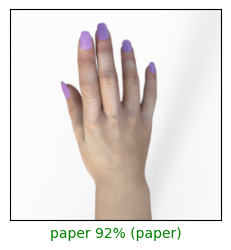

In [27]:
#@title Visualize the outputs { run: "auto" }
index = 0 #@param {type:"slider", min:0, max:9, step:1}
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(index, predictions, test_labels, test_imgs)
plt.show()

Create a file to save the labels.

In [28]:
with open('labels.txt', 'w') as f:
    f.write('\n'.join(class_names))

If you are running this notebook in a Colab, you can run the cell below to download the model and labels to your local disk.

**Note**: If the files do not download when you run the cell, try running the cell a second time. Your browser might prompt you to allow multiple files to be downloaded. 

In [29]:
try:
    from google.colab import files
    files.download('converted_model.tflite')
    files.download('labels.txt')
except:
    pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Prepare the Test Images for Download (Optional)

This part involves downloading additional test images for the Mobile Apps only in case you need to try out more samples

In [30]:
!mkdir -p test_images

In [31]:
from PIL import Image

for index, (image, label) in enumerate(test_batches.take(50)):
    image = tf.cast(image * 255.0, tf.uint8)
    image = tf.squeeze(image).numpy()
    pil_image = Image.fromarray(image)
    pil_image.save('test_images/{}_{}.jpg'.format(class_names[label[0]], index))

In [32]:
!ls test_images

paper_0.jpg   paper_27.jpg  rock_15.jpg  rock_38.jpg	  scissors_17.jpg
paper_12.jpg  paper_2.jpg   rock_1.jpg	 rock_39.jpg	  scissors_29.jpg
paper_14.jpg  paper_31.jpg  rock_20.jpg  rock_41.jpg	  scissors_33.jpg
paper_18.jpg  paper_3.jpg   rock_21.jpg  rock_42.jpg	  scissors_37.jpg
paper_19.jpg  paper_40.jpg  rock_28.jpg  rock_43.jpg	  scissors_46.jpg
paper_22.jpg  paper_45.jpg  rock_30.jpg  rock_44.jpg	  scissors_4.jpg
paper_23.jpg  paper_48.jpg  rock_32.jpg  rock_47.jpg	  scissors_5.jpg
paper_24.jpg  paper_49.jpg  rock_34.jpg  rock_9.jpg	  scissors_6.jpg
paper_25.jpg  rock_11.jpg   rock_35.jpg  scissors_10.jpg  scissors_7.jpg
paper_26.jpg  rock_13.jpg   rock_36.jpg  scissors_16.jpg  scissors_8.jpg


In [33]:
!zip -qq rps_test_images.zip -r test_images/

If you are running this notebook in a Colab, you can run the cell below to download the Zip file with the images to your local disk. 

**Note**: If the Zip file does not download when you run the cell, try running the cell a second time.

In [34]:
try:
    files.download('rps_test_images.zip')
except:
    pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>